<h1><center><font size="6">Regresion with GPlearn+LGB+XGB models</font></center></h1>

<h2><center><font size="4">Features used: Andrews+Tsfresh</font></center></h2>

<img src="" width="600"></img>

<br>

# <a id='0'>Content</a>


- <a href='#2'>Load Packages</a>  
- <a href='#3'>Data Import and Scaling</a>   
- <a href='#4'>Genetic Symbolic Regressor</a>
- <a href='#4-1'>GPlearn Runtime Management</a>
- <a href='#5'>Regression with LGB and XGB</a>
- <a href='#6'>Visualization Fitted Models vs  Time to Failure</a>  


# <a id='1'>Load packages</a>



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np
import pandas as pd
pd.options.display.precision = 15

import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
import signal
import gc
import time
import datetime
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, StandardScaler,QuantileTransformer
import pickle

from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
warnings.filterwarnings("ignore")
import os
print(os.listdir("../input"))
print(os.listdir("../input/gplearnmodels"))
# Any results you write to the current directory are saved as output.


['LANL-Earthquake-Prediction', 'gplearnmodels', 'andrewstsfreshv19']
['gp_model .pkl']


# <a id='3'>Data Import and Scaling</a>  

   
* Features: Andrews + Tsfresh ('c3','ar_coefficient','spkt_welch_density','fft_coefficient','autocorrelation','agg_autocorrelation','number_peaks','cwt_coefficients','ratio_beyond_r_sigma');  
* Labels : time to failure which gives the time until a failure occurs.



In [2]:
df=pd.read_csv('../input/andrewstsfreshv19/ExtFeaturestrain.csv')
test=pd.read_csv('../input/andrewstsfreshv19/ExtFeaturestest.csv')
print(df.shape)

X=df[df.columns.difference(['time_to_failure'])]
y=df['time_to_failure']

y_tr=y
scaler=MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(X.append(test))

train=pd.DataFrame(scaled[:X.shape[0]], columns=X.columns.values)
test=pd.DataFrame(scaled[-test.shape[0]:], columns=X.columns.values)
trainX, testX, trainy, testy = train_test_split(train, y, test_size=0.0,shuffle=True,random_state=42)

X_tr_scaled = trainX
X_test_scaled = test

(4194, 384)


# <a id='4'>GPlearn Symbolic Regressor </a>  

**This GPlearn section is atributed to https://www.kaggle.com/oguzkoroglu/andrews-new-script-genetic-program-and-gplearn**

In [3]:
est_gp = SymbolicRegressor(population_size=10000,
                               tournament_size=50,
                               generations=500, #you can set a high number then use est_gp.set_params(generations= number<220) to stop evolution
                               stopping_criteria=0.0,
                               p_crossover=0.9, p_subtree_mutation=0.0001, p_hoist_mutation=0.0001, p_point_mutation=0.0001,
                               max_samples=1.0, verbose=1,
                               #function_set = ('add', 'sub', 'mul', 'div', gp_tanh, 'sqrt', 'log', 'abs', 'neg', 'inv','max', 'min', 'tan', 'cos', 'sin'),
                               function_set = ('tan', 'add', 'sub', 'mul', 'div','max', 'min'),
                               metric = 'mean absolute error', warm_start=True,
                               n_jobs = -1, parsimony_coefficient=0.00003, random_state=11)

Load a pretrained model

In [4]:
with open('../input/gplearnmodels/gp_model .pkl', 'rb') as f:
    est_gp = pickle.load(f)


# <a id='4-1'>GPlearn Runtime Management </a>  


This code is used to stop the training process due to the kaggle limit on kernel runtime.
Train for n seconds and pickle/save resulting model.(continue the evolution process later)

In [ ]:
n=1500

class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

signal.signal(signal.SIGALRM, timeout_handler)


signal.alarm(n)   # seconds  
try:
    est_gp.fit(train, y)

except TimeoutException:
    #with open('gp_model.pkl', 'wb') as f: # uncomment to save model
        #pickle.dump(est_gp, f)
    print('function terminated')

In [5]:
print("This model was pretrained for {} generations".format(est_gp.run_details_['generation'][-1]))
est_gp.set_params(generations=est_gp.run_details_['generation'][-1]+1) #train for 1 more generation
est_gp.fit(train, y)

This model was pretrained for 402 generations
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
         function_set=('tan', 'add', 'sub', 'mul', 'div', 'max', 'min'),
         generations=403, init_depth=(2, 6), init_method='half and half',
         low_memory=False, max_samples=1.0, metric='mean absolute error',
         n_jobs=-1, p_crossover=0.9, p_hoist_mutation=0.0001,
         p_point_mutation=0.0001, p_point_replace=0.05,
         p_subtree_mutation=0.0001, parsimony_coefficient=3e-05,
         population_size=10000, random_state=11, stopping_criteria=0.0,
         tournament_size=50, verbose=1, warm_start=True)

In [6]:
#est_gp.fit(train, y)
y_gp = est_gp.predict(train)
gpLearn_MAE = mean_absolute_error(y_tr, y_gp)
print("gpGpiLearn MAE:", gpLearn_MAE)
with open('gp_model.pkl', 'wb') as f:
    pickle.dump(est_gp, f)

gpGpiLearn MAE: 1.9873760856318918


In [7]:
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = est_gp.predict(X_test_scaled)
submission.to_csv('submission.csv', index=True)
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.347062909735108
seg_0012b5,5.067702478999703
seg_00184e,5.305425199331310
seg_003339,7.967154360204320
seg_0042cc,6.319003429101173



# <a id='5'>Regression with LGB and XGB</a>  

Let's prepare the model.

LGB Parameters

In [9]:
params={'bagging_fraction': 0.63,
'boosting': 'gbdt',
'feature_fraction': 0.31,
'lambda_l1': 2.622427756417558,
'lambda_l2': 2.624427931714477,
'learning_rate': 0.041111529297691546,
'max_bin': 133,
'max_depth': 17,
'metric': 'RMSE',
'min_data_in_bin': 194,
'min_data_in_leaf': 11,
'num_leaves': 1058,
'objective': 'gamma',
'subsample': 0.9577983565538245}

In [10]:

prelgb1 = np.zeros(len(train))
mae = np.array([])
predictions0 = np.zeros(len(test))
feature_importance_df = pd.DataFrame()
#run model

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = train.columns.values

for fold_, (trn_idx, val_idx) in enumerate(folds.split(trainX,trainy.values)):
    strLog = "fold {}".format(fold_)
    
    X_tr, X_val = trainX.iloc[trn_idx], trainX.iloc[val_idx]
    y_tr, y_val = trainy.iloc[trn_idx], trainy.iloc[val_idx]

    print(strLog)
    
    model0 = lgb.LGBMRegressor(**params, n_estimators = 10000, n_jobs = -1)
    model0.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=500, 
              early_stopping_rounds=100)
    mae = np.append(mae, mean_absolute_error(y_val, model0.predict(X_val)))
    print("Fold: {} Validation MAE: {}".format(strLog,mae[fold_]))
    #predictions
    predictions0 += model0.predict(test, num_iteration=model0.best_iteration_) / folds.n_splits
    prelgb1[val_idx] =  model0.predict(X_val).reshape(-1,)
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(mae), np.std(mae)))
submission.time_to_failure = predictions0
submission.to_csv('submissionlgb0.csv',index=True)
submission.head()
prelgb1=pd.DataFrame({'id': trainy.index.values,'TTF': prelgb1}).set_index('id').sort_index()

fold 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	training's l1: 1.49236	training's rmse: 2.02095	valid_1's l1: 1.98369	valid_1's rmse: 2.61436
Fold: fold 0 Validation MAE: 1.9836865624444273
fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	training's l1: 1.29957	training's rmse: 1.7716	valid_1's l1: 1.9445	valid_1's rmse: 2.56675
Fold: fold 1 Validation MAE: 1.9445001270792437
fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	training's l1: 1.52292	training's rmse: 2.07977	valid_1's l1: 2.06386	valid_1's rmse: 2.67253
Fold: fold 2 Validation MAE: 2.06386420267997
fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[68]	training's l1: 1.42237	training's rmse: 1.92149	valid_1's l1: 1.95944	valid_1's rmse: 2.59423
Fold: fold 3 Validation MAE: 1.9594391329126

Submission of the blend with the gplearn and lgb models

In [11]:
blending1 = predictions0*1/2 + est_gp.predict(X_test_scaled)*1/2
submission['time_to_failure']=blending1
submission.to_csv('submissionblend1.csv',index=True)
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.121796108255097
seg_0012b5,5.129423634268862
seg_00184e,5.298129526132294
seg_003339,8.177504520702939
seg_0042cc,6.608312916522780


**XGB Parameters**

In [12]:
params ={'boosting': 'gblinear',
'colsample_bylevel': 0.87,
'colsample_bynode': 0.98,
'colsample_bytree': 0.63,
'eval_metric': 'mae',
'gamma': 2.3074997279871394,
'learning_rate': 0.19978743070807628,
'max_depth': 4,
'min_child_weight': 2.164915649342119,
'objective': 'reg:linear',
'reg_alpha': 2.5778910953585816,
'reg_lambda': 3.4511859649859136,
'subsample': 1.0,
'tree_method': 'exact'}

In [13]:
X=trainX
X_test=test

y=trainy
prexgb01 = np.zeros(len(train))
prediction01 = np.zeros(len(X_test))

n_fold = 5
folds = KFold(n_splits=n_fold,  random_state=11)
scores = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    print('Fold', fold_n, 'started at', time.ctime())
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
    
    train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
    valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

    watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
    model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
    
    y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
    
    
    y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
    prexgb01[valid_index] = y_pred_valid.reshape(-1,)
    
    
    scores.append(mean_absolute_error(y_valid, y_pred_valid))
    
    
    prediction01 += y_pred / folds.n_splits
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
submission.time_to_failure = prediction01
submission.to_csv('submissionxgb0.csv',index=True)
submission.head()
prexgb01=pd.DataFrame({'id': trainy.index.values,'TTF': prexgb01}).set_index('id').sort_index()

Fold 0 started at Fri May 10 00:57:20 2019
[0]	train-mae:4.27921	valid_data-mae:4.25281
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[14]	train-mae:1.79054	valid_data-mae:2.05709

Fold 1 started at Fri May 10 00:57:32 2019
[0]	train-mae:4.28625	valid_data-mae:4.24408
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[13]	train-mae:1.80102	valid_data-mae:2.07294

Fold 2 started at Fri May 10 00:57:43 2019
[0]	train-mae:4.31145	valid_data-mae:4.10869
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[10]	train-mae:1.86587	valid_data-mae:2.0272

Fold 3 started at Fri May 10 00:57:55 2019
[0]	train-mae

Submission of the blend with the gplearn , lgb and xgb models

In [14]:
blending = (predictions0 + prediction01 + est_gp.predict(X_test_scaled))*1/3
submission['time_to_failure']=blending
submission.to_csv('submissionblend0.csv',index=True)
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.040465399271454
seg_0012b5,5.302999546831199
seg_00184e,5.339386242862507
seg_003339,8.185282734426247
seg_0042cc,6.759204157038238



# <a id='6'>Visualization Fitted Models vs  Time to Failure</a> 

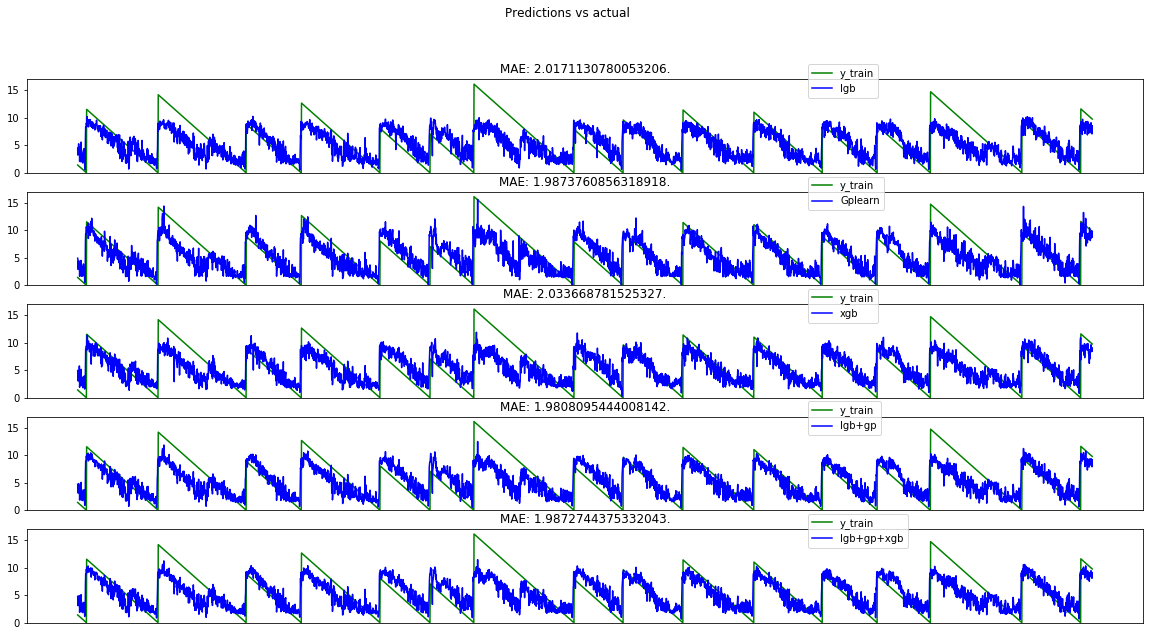

In [15]:
y=y.sort_index()
plt.figure(figsize=(20, 10))
plt.subplot(5, 1, 1)
plt.plot(y, color='g', label='y_train')
plt.plot(prelgb1['TTF'].values, color='b', label='lgb')
plt.legend(loc=(0.7, 0.8));
plt.ylim((0,17))
plt.title('MAE: {}.'.format(mean_absolute_error(y, prelgb1['TTF'].values)));
plt.xticks([])
plt.subplot(5, 1, 2)
plt.plot(y, color='g', label='y_train')
plt.plot(y_gp, color='b', label='Gplearn')
plt.legend(loc=(0.7, 0.8));
plt.ylim((0,17))
plt.title('MAE: {}.'.format(mean_absolute_error(y, y_gp)));
plt.xticks([])
plt.subplot(5, 1, 3)
plt.plot(y, color='g', label='y_train')
plt.plot(prexgb01['TTF'].values, color='b', label='xgb')
plt.legend(loc=(0.7, 0.8));
plt.title('MAE: {}.'.format(mean_absolute_error(y, prexgb01['TTF'].values)));
plt.ylim((0,17))
plt.legend(loc=(0.7, 0.8));
plt.suptitle('Predictions vs actual');
plt.xticks([])
plt.subplot(5, 1, 4)
plt.plot(y, color='g', label='y_train')
plt.plot((prelgb1['TTF'].values  + y_gp)*1/2, color='b', label='lgb+gp')
plt.legend(loc=(0.7, 0.8));
plt.title('MAE: {}.'.format(mean_absolute_error(y,(prelgb1['TTF'].values  + y_gp)*1/2)))
plt.ylim((0,17))
plt.xticks([])
plt.subplot(5, 1, 5)
plt.plot(y, color='g', label='y_train')
plt.plot((prelgb1['TTF'].values + prexgb01['TTF'].values + y_gp)*1/3, color='b', label='lgb+gp+xgb')
plt.legend(loc=(0.7, 0.8));
plt.title('MAE: {}.'.format(mean_absolute_error(y,(prelgb1['TTF'].values + prexgb01['TTF'].values + y_gp)*1/3)))
plt.ylim((0,17))
plt.xticks([])
plt.legend(loc=(0.7, 0.8));
plt.suptitle('Predictions vs actual');
